In [1]:
import glob, os, sys
# sys.path.append("..")
# from utils.utils import *
import uproot, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
from xgboost import XGBClassifier 
import pickle
import shap
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
Ztt_inc = [
          700792, 700793, 700794,
          700901, 700902, 700903,
          700360 #ZttEWK
]

ttV = [
    410155, # ttW
    504330, 504334, 504338, 504342, 504346,
    304014, # 3t
]

# Diboson
VV = [
    700488, 700489, 
    700491, 700492, 700493, #700494, 
    700495, #700496,
    #700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top = [
    410470, 410471,
    #410472, ##hard coded to skip over this. why?
    410644, 410645, 410646, 410647, 410658, 410659
]

# W(tau/mu/e + nu) + jets
W = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc = [
    700320, 700321, 700322, 700467, 700468, 700469, # Zee 
    700323, 700324, 700325, 700470, 700471, 700472,# Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

# Signal samples (new)
ggH = [
    345120, 345121, 345122, 345123,
    345324, # ggHWW
    # 600686, # ggZH
    ]
VBFH = [
    346190, 346191, 346192, 346193,
    345948, # VBFHWW
]
WH = [345211, 345212]
ZH = [345217]
ttH = [346343,346344,346345]

LUMI = {
    '15': 3244.54,
    '16': 33402.2,
    '17': 44630.6,
    '18': 58791.6,    
}

LUMI_SCALE = {
    '15': (3244.54+33402.2)/3244.54,
    '16': (3244.54+33402.2)/33402.2,
    '17': 1,
    '18': 1,
}

In [3]:
############## OLD DSIDs ##############

# Ztt_inc = [
#     # mc23 DSIDs
#     # 700621, 700622, 700623, 
#     # 700642, 700643, 700644,
#     # 700703, 700704, 700705,
#     # mc20 DSIDs
#     700792, 700793, 700794,
#     700360, # Ztautau2jets
#     ]

# ttV = [
#     410155, # ttW
#     # 410218, 410219, 410220, # ttZs
#     304014, # 3t, 4t #! missing these samples
#     ]

# # Diboson
# VV = [
#     700488, 700489, 
#     700491, 700492, 700493, 700494, 700495, 700496,
#     700600, 700601, 700602, 700603, 700604, 700605, 
# ]

# # Single-Top and ttbar (new samples now!)
# Top = [
#     410470, 410471, 
#     # 410472, 
#     410644, 410645, 410646, 410647, 410658, 410659
# ]

# # W(tau/mu/e + nu) + jets
# W = [
#     700338, 700339, 700340, # Wenu
#     700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
#     700344, 700345, 700346, # WtaunuL
#     700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
#     700362, 700363, 700364, # W lep + 2jets
# ]

# Zll_inc = [
#     700320, 700321, 700322, # Zee 
#     700323, 700324, 700325, # Zmumu
#     700358, #Zee2jets
#     700359, #Zmumu2jets
# ]

# # Zee = [
# #     700320, 700321, 700322, # Zee
# #     700358, # Zee2jets
# # ]

# # Zmumu = [
# #     700323, 700324, 700325, # Zmumu
# #     700359, # Zmumu2jetss
# # ]

# # Signal samples (new)
# ggH = [
#     345120, 345121, 345122, 345123
#     ]
# VBFH = [
#     # mc20 DSIDs
#     346190, 346191, 346192, 346193,
# ]
# WH = [345211, 345212]
# ZH = [345217]
# ttH = [346343,346344,346345]

# LUMI = {
#     '15': 3244.54,
#     '16': 33402.2,
#     '17': 44630.6,
#     '18': 58791.6,    
# }

# LUMI_SCALE = {
#     '15': (3244.54+33402.2)/3244.54,
#     '16': (3244.54+33402.2)/33402.2,
#     '17': 1,
#     '18': 1,
# }

In [4]:
# # Combine all lists into one set to get unique numbers
# all_numbers = set(ZttQCD + ZttEWK + ttV + VV + Top + W + Zll_inc + Zee + Zmumu + ggH + VBFH + WH + ZH + ttH + ggHWW + VBFHWW + ggH_He7 + VBFH_He7 + ZH_He7)

# # Count unique numbers
# unique_count = len(all_numbers)
# print("Unique count:", unique_count)

# # Path to the directory
# path = "/global/homes/a/agarabag/pscratch/ditdau_samples/new_V01/V01/mc/ditau_hh/mc20e/nom"

# # List all directories in the specified path
# dir_names = os.listdir(path)

# # Extract the "a_number" part from each directory name
# numbers_in_dirs = set()
# for dir_name in dir_names:
#     parts = dir_name.split('.')
#     if len(parts) > 3:
#         a_number = int(parts[4])
#         numbers_in_dirs.add(a_number)

# # Check for matches with all_numbers
# print(len(numbers_in_dirs))
# matches = all_numbers.intersection(numbers_in_dirs)
# non_matches = numbers_in_dirs - all_numbers

# # Print the matches and non-matches
# print("Matching numbers:", matches)
# print("Non-matching numbers:", non_matches)

In [5]:
def read_event_weights(event_id, data_year):
    # file_path = '/home/agarabag/ditau_analysis/boom/data/xsec_sow/xsec_sumofweights_nom.json'
    file_path = './xsec_sumofweights_nom.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])
    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            print("processing", event_id)
            results[event_id] = event_weight / sum_event_weights
    return results


In [6]:
# Define datasets and processes
datasets = ['mc20d', 'mc20a', 'mc20e']
# datasets = ['mc20d']

categories = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH, 
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top, 
        'W': W, 'Zll_inc': Zll_inc, #'ttV': ttV
    }
}

# Initialize a dictionary to store weights
weights = {}

# Fetch weights for each dataset and category
for dataset in datasets:
    weights[dataset] = {}
    for category, processes in categories.items():
        weights[dataset][category] = {}
        for process_name, process_list in processes.items():
            key = f"{process_name}_ws_{dataset[-1]}"
            weights[dataset][category][key] = fetch_weights(process_list, dataset)

weights

processing 346190
processing 346191
processing 346192
processing 346193
processing 345948
processing 345120
processing 345121
processing 345122
processing 345123
processing 345324
processing 345211
processing 345212
processing 345217
processing 346343
processing 346344
processing 346345
processing 700792
processing 700793
processing 700794
processing 700901
processing 700902
processing 700903
processing 700360
processing 700488
processing 700489
processing 700491
processing 700492
processing 700493
processing 700495
processing 410470
processing 410471
processing 410644
processing 410645
processing 410646
processing 410647
processing 410658
processing 410659
processing 700338
processing 700339
processing 700340
processing 700341
processing 700342
processing 700343
processing 700344
processing 700345
processing 700346
processing 700347
processing 700348
processing 700349
processing 700362
processing 700363
processing 700364
processing 700320
processing 700321
processing 700322
processing

{'mc20d': {'signal': {'VBFH_ws_d': {346190: 3.636104280524635e-09,
    346191: 1.0190964744828225e-08,
    346192: 1.0228715974527338e-08,
    346193: 1.2459960373122468e-08,
    345948: 4.670741676932838e-09},
   'ggH_ws_d': {345120: 3.7772811117247e-09,
    345121: 1.4441548725075489e-08,
    345122: 1.443218774025719e-08,
    345123: 5.534380625346609e-09,
    345324: 6.270245333472206e-09},
   'WH_ws_d': {345211: 2.4693623043284394e-07, 345212: 2.440023027990859e-07},
   'ZH_ws_d': {345217: 1.3553478676015695e-07},
   'ttH_ws_d': {346343: 1.4809819291555295e-07,
    346344: 6.659359232863082e-08,
    346345: 1.6085365744952297e-07}},
  'background': {'Ztt_inc_ws_d': {700792: 7.438056333700753e-13,
    700793: 1.0134884723827427e-12,
    700794: 6.667861381856553e-13,
    700901: 1.6006591452064961e-12,
    700902: 1.4718988606024973e-12,
    700903: 1.6668702179446763e-12,
    700360: 1.1427215359842169e-10},
   'VV_ws_d': {700488: 6.643804540907577e-12,
    700489: 2.4000235006408

In [7]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',
'NOMINAL_pileup_random_run_number',
'ditau_obj_bdt_score',
'ditau_obj_omni_score',
'ditau_obj_leadsubjet_charge',
'ditau_obj_leadsubjet_n_core_tracks',
'ditau_obj_leadsubjet_p4',
'ditau_obj_nSubjets',
'ditau_obj_n_tracks',
'ditau_obj_p4',
'ditau_obj_subleadsubjet_charge',
'ditau_obj_subleadsubjet_n_core_tracks',
'ditau_obj_subleadsubjet_p4',
'jets_p4',
'event_number',
'met_p4',
'met_sumet',
'met_hpto_p4',
'event_is_bad_batman',
'NOMINAL_pileup_combined_weight',
'n_bjets_DL1dv01_FixedCutBEff_70',
'weight_mc']

data_branches = \
[
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_omni_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'jets_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [8]:
# path_template = '/home/agarabag/data/ditau/new_test/T01/mc/ditau_hh/{year}/nom/user.*.{dsid}.*/user.*.root'
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/mc/ditau_hh/{year}/nom/user.*.{dsid}.*/user.*.root'
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/mc/ditau_hh/{year}/nom/user.shhirose.*{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18'):
    out = []
    hlt_branches = {
        '15': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100', 'HLT_xe70_mht', 'HLT_j420_a10r_L1J100', 'HLT_xe110_mht_L1XE50'],
        '16': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100', 'HLT_xe70_mht', 'HLT_j420_a10r_L1J100', 'HLT_xe110_mht_L1XE50'],
        '17': ['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100', 'HLT_xe110_pufit_L1XE55'], 
        '18': ['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111', 'HLT_xe110_pufit_xe70_L1XE50'] 
    }
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')

                # Handling 2015 and 2016 conditions
                if year in ['15', '16']:
                    mask_15 = (events['NOMINAL_pileup_random_run_number'] <= 284484) & (events['NOMINAL_pileup_random_run_number'] > 0)
                    mask_16 = (events['NOMINAL_pileup_random_run_number'] > 284484) & (events['NOMINAL_pileup_random_run_number'] <= 311563)
                    events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks']) * events['weight_mc'] * events['NOMINAL_pileup_combined_weight']

                    # Assign weights based on the run number
                    events['weight'] = ak.where(mask_15,
                                                events['weight'] * LUMI_SCALE['15'] * LUMI['15'],
                                                ak.where(mask_16,
                                                         events['weight'] * LUMI_SCALE['16'] * LUMI['16'],
                                                         events['weight']))
                    
                    if not ak.any(mask_15 | mask_16):
                        print(f"Event number out of range in file: {file}")
                elif year in ['17', '18']:
                    events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                       events['weight_mc'] * events['NOMINAL_pileup_combined_weight'] * \
                                       LUMI_SCALE[year] * LUMI[year]
                
                out = ak.concatenate((out, events))

        print(f"Processed year: {year}, files for DSID {dsid_list}, Time spent: {round(time.time()-s, 4)} s")
    
    return out


In [9]:
# Year mapping
year_map = {
    'mc20e': '18',
    'mc20d': '17', 
    'mc20a': '15'
}
# year_map = {
#     'mc20d': '17', 
# }

# Process mapping
processes = {
    'signal': {
        'VBFH': VBFH, 'ggH': ggH, 'WH': WH, 'ZH': ZH, 'ttH': ttH
    },
    'background': {
        'Ztt_inc': Ztt_inc, 'VV': VV, 'Top': Top,
        'W': W, 'Zll_inc': Zll_inc, #'ttV': ttV
    }
}

total_mc = {}
for dataset in ['mc20e', 'mc20d', 'mc20a']:
# for dataset in ['mc20d']:
    suffix = dataset[-1]
    year = year_map[dataset]
    dataset_results = {}
    for category, procs in processes.items():
        for proc_name, proc_list in procs.items():
            weight_key = f"{proc_name}_ws_{suffix}"
            weight = weights[dataset][category][weight_key]
            var_name = f"{proc_name}_{suffix}"
            dataset_results[var_name] = read_root(proc_list, weight, year_id=dataset, year=year)
    total_mc[dataset] = dataset_results

Processed year: 18, files for DSID [346190, 346191, 346192, 346193, 345948], Time spent: 0.1597 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193, 345948], Time spent: 0.1461 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193, 345948], Time spent: 0.147 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193, 345948], Time spent: 0.6188 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193, 345948], Time spent: 0.1744 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324], Time spent: 0.6082 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324], Time spent: 0.2881 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324], Time spent: 0.436 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324], Time spent: 0.4209 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123, 345324], Time spent: 0.3964 s
Processed year: 18, fi

In [10]:
## load data
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/data/ditau_hh/data{year}/user.*/user.*.root'
# path_template_data = '/home/agarabag/data/ditau/new_test/T01/data/ditau_hh/data{year}/user.*/user.*.root'

def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '15':
            branches_read.extend(['HLT_j360', 'HLT_xe70_mht'])
        elif year == '16':
            branches_read.extend(['HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100', 'HLT_xe110_mht_L1XE50'])
        elif year == '17':
            branches_read.extend(['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100', 'HLT_xe110_pufit_L1XE55'])
        elif year == '18':
            branches_read.extend(['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111', 'HLT_xe110_pufit_xe70_L1XE50'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_18 = read_data_root(year='18')
data_17 = read_data_root(year='17')
data_16 = read_data_root(year='16')
data_15 = read_data_root(year='15')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/data/ditau_hh/data18/user.shhirose.Htt_b101.data18_13TeV.periodAllYear.physics_Main.PHYS.grp18_v01_p6479.w_0_HS/user.shhirose.44271756._000200.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/data/ditau_hh/data18/user.shhirose.Htt_b101.data18_13TeV.periodAllYear.physics_Main.PHYS.grp18_v01_p6479.w_0_HS/user.shhirose.44271756._000366.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/data/ditau_hh/data18/user.shhirose.Htt_b101.data18_13TeV.periodAllYear.physics_Main.PHYS.grp18_v01_p6479.w_0_HS/user.shhirose.44271756._000330.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/T03/data/ditau_hh/data18/user.shhirose.Htt_b101.data18_13TeV.periodAllYear.physics_Main.PHYS.grp18_v01_p6479.w_0_HS/user.shhirose.44271756._000097.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/new_s

In [10]:
def save_raw_data(data, data_type='MC'):
    """Process and save raw data before any cuts"""
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    output_file = f'/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/raw_{data_type.lower()}_data.pkl'
    
    # Save data directly
    with open(output_file, 'wb') as f:
        pickle.dump(data, f)
    print(f"Saved raw {data_type} data to {output_file}")
    
    return data

save_raw_data(total_mc, 'MC')
save_raw_data({'data_18': data_18, 'data_17': data_17, 
                          'data_16': data_16, 'data_15': data_15}, 'data')


Saved raw MC data to /global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/raw_mc_data.pkl


{'mc20e': {'VBFH_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='11656 * {ditau_obj_tr...'>,
  'ggH_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='7383 * {ditau_obj_tru...'>,
  'WH_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1269 * {ditau_obj_tru...'>,
  'ZH_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1425 * {ditau_obj_tru...'>,
  'ttH_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='221814 * {ditau_obj_t...'>,
  'Ztt_inc_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='2630109 * {ditau_obj_...'>,
  'VV_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='244325 * {ditau_obj_t...'>,
  'Top_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='981832 * {ditau_obj_t...'>,
  'W_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='1769042 * {ditau_obj_...'>,
  'Zll_inc_e': <Array [{...}, {...}, {...}, ..., {...}, {...}] type='718411 * {ditau_obj_t...'>},
 'mc20d': {'VBFH_d': <Array [{...}, {...}, {...}, ..., {

In [2]:
ditau_id_cut = 0.9993

def data_Cut(t, year):    
    # ditau_obj_pt = vector.zip(
    #     {
    #     'px': t['ditau_obj_p4'].fP.fX,
    #     'py': t['ditau_obj_p4'].fP.fY,
    #     'pz': t['ditau_obj_p4'].fP.fZ,
    #     'energy': t['ditau_obj_p4'].fE
    #     }
    # ).pt
    # lead_jet_pt = vector.zip(
    #     {
    #     'px': ak.Array([obj.fP.fX for obj in t['jets_p4'][:, 0]]),
    #     'py': ak.Array([obj.fP.fY for obj in t['jets_p4'][:, 0]]),
    #     'pz': ak.Array([obj.fP.fZ for obj in t['jets_p4'][:, 0]]),
    #     'energy': ak.Array([obj.fE for obj in t['jets_p4'][:, 0]])
    #     }
    # ).pt
    # met_pt = vector.zip({
    #     'px': t['met_p4'].fP.fX,
    #     'py': t['met_p4'].fP.fY,
    #     'pz': t['met_p4'].fP.fZ,
    #     'energy': t['met_p4'].fE
    # }).pt
    
    if year == '15':
        hlt_cut = (t['HLT_j360']) | \
                  (t['HLT_xe70_mht'])
    elif year == '16':
        hlt_cut = (t['HLT_j380']) | \
                  ((t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100'])) | \
                  (t['HLT_xe110_mht_L1XE50'])
    elif year == '17':
        hlt_cut = (t['HLT_j400']) | \
                  (t['HLT_j440_a10_lcw_subjes_L1J100']) | \
                  (t['HLT_xe110_pufit_L1XE55'])
    elif year == '18':
        hlt_cut = (t['HLT_j420']) | \
                  ((t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111'])) | \
                  (t['HLT_xe110_pufit_xe70_L1XE50'])
    else:
        raise ValueError(f"Unsupported year: {year}") 
        
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] < ditau_id_cut) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]

def mc_Cut(t, year):
    # ditau_obj_pt = vector.zip(
    #     {
    #     'px': t['ditau_obj_p4'].fP.fX,
    #     'py': t['ditau_obj_p4'].fP.fY,
    #     'pz': t['ditau_obj_p4'].fP.fZ,
    #     'energy': t['ditau_obj_p4'].fE
    #     }
    # ).pt    
    # lead_jet_pt = vector.zip(
    #     {
    #     'px': ak.Array([obj.fP.fX for obj in t['jets_p4'][:, 0]]),
    #     'py': ak.Array([obj.fP.fY for obj in t['jets_p4'][:, 0]]),
    #     'pz': ak.Array([obj.fP.fZ for obj in t['jets_p4'][:, 0]]),
    #     'energy': ak.Array([obj.fE for obj in t['jets_p4'][:, 0]])
    #     }
    # ).pt
    # met_pt = vector.zip({
    #     'px': t['met_p4'].fP.fX,
    #     'py': t['met_p4'].fP.fY,
    #     'pz': t['met_p4'].fP.fZ,
    #     'energy': t['met_p4'].fE
    # }).pt
    
    if year == '15' or year == '16':
        mask_15 = (t['NOMINAL_pileup_random_run_number'] <= 284484) & (t['NOMINAL_pileup_random_run_number'] > 0)
        mask_16 = (t['NOMINAL_pileup_random_run_number'] > 284484) & (t['NOMINAL_pileup_random_run_number'] <= 311563)
        hlt_cut_15 = (t['HLT_j360']) | \
                     (t['HLT_xe70_mht'])
        
        hlt_cut_16 = (t['HLT_j380']) | \
                     ((t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100'])) | \
                     (t['HLT_xe110_mht_L1XE50'])
        
        hlt_cut = (mask_15 & hlt_cut_15) | (mask_16 & hlt_cut_16)
    elif year == '17':
        hlt_cut = (t['HLT_j400']) | \
                  (t['HLT_j440_a10_lcw_subjes_L1J100']) | \
                  (t['HLT_xe110_pufit_L1XE55'])
        
    elif year == '18':
        hlt_cut = (t['HLT_j420']) | \
                  ((t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111'])) | \
                  (t['HLT_xe110_pufit_xe70_L1XE50'])   
    else:
        raise ValueError(f"Unsupported year: {year}")

    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_omni_score'] >= ditau_id_cut) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)
    return t[final_cut]


In [3]:
def apply_cuts(data, data_type='MC'):
    """
    Apply cuts to both MC and real data
    data_type: 'MC' or 'data'
    """
    if data_type not in ['MC', 'data']:
        raise ValueError("data_type must be either 'MC' or 'data'")
    
    cut_results = {}
    
    if data_type == 'MC':
        year_map = {
        'mc20e': '18',
        'mc20d': '17', 
        'mc20a': '15'
        }
        # Handle MC data structure (nested dictionary)
        for dataset, results in data.items():
            year = year_map[dataset]
            cut_results[dataset] = {}
            
            print(f"Applying MC cuts to {dataset} (year {year})...")
            for var_name, sample in results.items():
                try:
                    cut_results[dataset][var_name] = mc_Cut(sample, year)
                    print(f"Processed {var_name}")
                except Exception as e:
                    print(f"Error processing {var_name}: {str(e)}")
                    cut_results[dataset][var_name] = None
    else:
        # Handle real data (direct samples)
        data_vars = {
            'data_18': ('18', data['data_18']),
            'data_17': ('17', data['data_17']),
            'data_16': ('16', data['data_16']),
            'data_15': ('15', data['data_15'])
        }
        for name, (year, sample) in data_vars.items():
            print(name, year, sample)
            try:
                cut_results[name] = data_Cut(sample, year)
                print(f"Processed {name}")
            except Exception as e:
                print(f"Error processing {name}: {str(e)}")
                cut_results[name] = None

    return cut_results


In [4]:
with open('/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/raw_mc_data.pkl', 'rb') as f:
    uncut_mc = pickle.load(f)

with open('/global/homes/a/agarabag/pscratch/ditdau_samples/new_samples/raw_data_data.pkl', 'rb') as f:
    uncut_data = pickle.load(f)


In [5]:
# cut_data = apply_cuts({'data_18': data_18, 'data_17': data_17, 
#                        'data_16': data_16, 'data_15': data_15}, data_type='data')
# # cut_data = apply_cuts({'data_17': data_17}, data_type='data')
# cut_mc = apply_cuts(total_mc, data_type='MC')

In [6]:
cut_data = apply_cuts({'data_18': uncut_data['data_18'], 'data_17': uncut_data['data_17'], 
                       'data_16': uncut_data['data_16'], 'data_15': uncut_data['data_15']}, data_type='data')
cut_mc = apply_cuts(uncut_mc, data_type='MC')

data_18 18 [{event_number: 398088851, met_p4: {fP: {...}, ...}, met_sumet: 623, ...}, ...]
Processed data_18
data_17 17 [{event_number: 2152299555, met_p4: {fP: {...}, ...}, met_sumet: 641, ...}, ...]
Processed data_17
data_16 16 [{event_number: 630935047, met_p4: {fP: {...}, ...}, met_sumet: 864, ...}, ...]
Processed data_16
data_15 15 [{event_number: 418819077, met_p4: {fP: {...}, ...}, met_sumet: 664, ...}, ...]
Processed data_15
Applying MC cuts to mc20e (year 18)...
Processed VBFH_e
Processed ggH_e
Processed WH_e
Processed ZH_e
Processed ttH_e
Processed Ztt_inc_e
Processed VV_e
Processed Top_e
Processed W_e
Processed Zll_inc_e
Applying MC cuts to mc20d (year 17)...
Processed VBFH_d
Processed ggH_d
Processed WH_d
Processed ZH_d
Processed ttH_d
Processed Ztt_inc_d
Processed VV_d
Processed Top_d
Processed W_d
Processed Zll_inc_d
Applying MC cuts to mc20a (year 15)...
Processed VBFH_a
Processed ggH_a
Processed WH_a
Processed ZH_a
Processed ttH_a
Processed Ztt_inc_a
Processed VV_a
Proc

In [7]:
def combine_mc_years(cut_mc):    
    combined = {}
    # Get base process names (without year suffix)
    base_processes = set()
    for dataset in cut_mc.values():
        for proc in dataset.keys():
            base_name = proc.rsplit('_', 1)[0]  # Remove _e, _d, _a suffix
            base_processes.add(base_name)
    
    # Combine each process across years
    for base_proc in base_processes:
        year_data = []
        for dataset in ['mc20e', 'mc20d', 'mc20a']:
        # for dataset in ['mc20d']:
            proc_name = f"{base_proc}_{dataset[-1]}"
            if proc_name in cut_mc[dataset]:
                year_data.append(cut_mc[dataset][proc_name])
        
        # Combine using awkward array concatenation
        if year_data:
            combined[base_proc] = ak.concatenate(year_data)
            print(f"Combined {base_proc} across years")
    
    return combined

def combine_data_years(cut_data):    
    # Extract arrays from all years
    data_arrays = [
        cut_data['data_18'],
        cut_data['data_17'],
        cut_data['data_16'],
        cut_data['data_15']
    ]
    
    # Combine using awkward array concatenation
    combined_data = ak.concatenate(data_arrays)
    print(f"Combined data from all years: {len(combined_data)} events")
    
    return combined_data

In [8]:
combined_mc = combine_mc_years(cut_mc)
combines_data = combine_data_years(cut_data)

Combined Zll_inc across years
Combined Ztt_inc across years
Combined VV across years
Combined ZH across years
Combined WH across years
Combined ggH across years
Combined ttH across years
Combined Top across years
Combined W across years
Combined VBFH across years
Combined data from all years: 245216 events


In [9]:
#combine all mc the samples
vbfh_cut = combined_mc['VBFH']
ggh_cut = combined_mc['ggH']
wh_cut = combined_mc['WH']
zh_cut = combined_mc['ZH']
tth_cut = combined_mc['ttH']
ztt_inc_cut = combined_mc['Ztt_inc']
# ttv_cut = combined_mc['ttV']
vv_cut = combined_mc['VV']
top_cut = combined_mc['Top']
w_cut = combined_mc['W']
zll_inc_cut = combined_mc['Zll_inc']

#combine all data samples
data_cut = combines_data
print("#fakes:", len(data_cut))

#fakes: 245216


In [10]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []

    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [11]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     """Load 3D fake factor histograms"""
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["3D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
#         "h_ff_1p3p": file["3D_FF_1p3p"].to_hist(),
#         "h_ff_3p3p": file["3D_FF_3p3p"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms):
#     """Calculate fake factors using 3D histograms with axes: (delta_r, lead_pt, sublead_pt)"""
#     weights = []
    
#     for lead, sublead, l_pt, s_pt, dr in zip(leadNTracks, subleadNTracks, 
#                                             lead_pt, sublead_pt, delta_r):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         try:
#             if prongness == 1:
#                 hist = histograms["h_ff_1p1p"]
#                 # Reordered indices to match histogram structure
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             elif prongness == 2:
#                 hist = histograms["h_ff_1p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             elif prongness == 3:
#                 hist = histograms["h_ff_3p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 lead_idx = hist.axes[1].index(l_pt)
#                 sublead_idx = hist.axes[2].index(s_pt)
#                 weight = hist.values()[delta_r_idx, lead_idx, sublead_idx]
                
#             else:
#                 print(f"Warning: Invalid prongness value: {prongness}")
#                 weight = -888
                
#         except IndexError:
#             print(f"Warning: Value out of histogram bounds: delta_r={dr}, lead_pt={l_pt}, sublead_pt={s_pt}")
#             weight = -999

#         if weight < 0:
#             print(f"Warning: Negative weight: {weight}")
#             weight = 1
            
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [12]:
# ff_scale = 1

# def determine_prong(leadNTracks, subleadNTracks):
#     if leadNTracks == 1 and subleadNTracks == 1:
#         return 1
#     elif leadNTracks == 3 and subleadNTracks == 1:
#         return 2
#     elif leadNTracks == 1 and subleadNTracks == 3:
#         return 2
#     elif leadNTracks == 3 and subleadNTracks == 3:
#         return 3
#     else:
#         return -1

# def load_histograms(root_file):
#     file = uproot.open(root_file)
#     histograms = {
#         "h_ff_1p1p": file["2D_FF_1p1p"].to_hist(),  # Assuming these are the 3D histogram names
#         "h_ff_1p3p": file["2D_FF_1p3p"].to_hist(),
#         "h_ff_3p3p": file["2D_FF_3p3p"].to_hist()
#     }
#     return histograms

# def fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms):
#     weights = []
    
#     for lead, sublead, s_pt, dr in zip(leadNTracks, subleadNTracks, sublead_pt, delta_r):
#         prongness = determine_prong(lead, sublead)
#         weight = 0
        
#         try:
#             if prongness == 1:
#                 hist = histograms["h_ff_1p1p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             elif prongness == 2:
#                 hist = histograms["h_ff_1p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             elif prongness == 3:
#                 hist = histograms["h_ff_3p3p"]
#                 delta_r_idx = hist.axes[0].index(dr)
#                 sublead_idx = hist.axes[1].index(s_pt)
#                 weight = hist.values()[delta_r_idx, sublead_idx]
                
#             else:
#                 print(f"Warning: Invalid prongness value: {prongness}")
#                 weight = -888
                
#         except IndexError:
#             print(f"Warning: Value out of histogram bounds: delta_r={dr}, sublead_pt={s_pt}")
#             weight = -999

#         if weight < 0:
#             print(f"Warning: Negative weight: {weight}")
#             weight = 1
            
#         weights.append(weight)
    
#     return [w * ff_scale for w in weights]


In [13]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt_ff"].to_hist(),
        "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt_ff"].to_hist(),
        "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt_ff"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, histograms):
    weights = []
    
    for lead, sublead, sublead_pt in zip(leadNTracks, subleadNTracks, sublead_pt):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        if prongness == 1:
            bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p1p"].values()[bin_idx]
        elif prongness == 2:
            bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p3p"].values()[bin_idx]
        elif prongness == 3:
            bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_3p3p"].values()[bin_idx]
        else:
            weight = -1
        
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [14]:
def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [15]:
def Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.zip(
        {
        'px': t['met_p4'].fP.fX, 
        'py': t['met_p4'].fP.fY,
        'pz': t['met_p4'].fP.fZ,
        'energy': t['met_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(leadsubjet_p4 + subleadsubjet_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + (leadsubjet_p4 + subleadsubjet_p4)).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
            met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
            t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

def Data_Var(t):
    leadsubjet_p4 = vector.zip(
        {
        'px': t['ditau_obj_leadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_leadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_leadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_leadsubjet_p4'].fE
        }
    )
    subleadsubjet_p4 = vector.zip(
        {
        'px':t['ditau_obj_subleadsubjet_p4'].fP.fX,
        'py':t['ditau_obj_subleadsubjet_p4'].fP.fY,
        'pz':t['ditau_obj_subleadsubjet_p4'].fP.fZ,
        'energy':t['ditau_obj_subleadsubjet_p4'].fE
        }
    )
    ditau_p4 = vector.zip(
        {
        'px':t['ditau_obj_p4'].fP.fX,
        'py':t['ditau_obj_p4'].fP.fY,
        'pz':t['ditau_obj_p4'].fP.fZ,
        'energy':t['ditau_obj_p4'].fE
        }
    )
    delta_phi = leadsubjet_p4.deltaphi(subleadsubjet_p4)
    delta_eta = leadsubjet_p4.deltaeta(subleadsubjet_p4)
    delta_R = leadsubjet_p4.deltaR(subleadsubjet_p4)
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = leadsubjet_p4.deltaR(ditau_p4)
    delta_eta_lead = leadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_lead = leadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = subleadsubjet_p4.deltaR(ditau_p4)
    delta_eta_sublead = subleadsubjet_p4.deltaeta(ditau_p4)
    delta_phi_sublead = subleadsubjet_p4.deltaphi(ditau_p4)
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    event_id = t['event_number']
    
    ######
    histograms = load_histograms("./FF_hadhad_ratio_1d.root")

    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    delta_r = np.array(delta_R)
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, delta_r, histograms) ###3d
    # fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, delta_r, histograms) ###2d
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, sublead_pt, histograms) ###1d

    ######
    ######
    met_2d = vector.zip(
        {
        'px': t['met_p4'].fP.fX, 
        'py': t['met_p4'].fP.fY,
        'pz': t['met_p4'].fP.fZ,
        'energy': t['met_p4'].fE
        }
    ) 
    met_pt = met_2d.pt
    met_phi = met_2d.phi
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######

    #delta phi between met and ditau
    delta_phi_met_ditau = met_2d.deltaphi(leadsubjet_p4 + subleadsubjet_p4)

    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + (leadsubjet_p4 + subleadsubjet_p4)).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_omni_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
            t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta, delta_phi_met_ditau]

In [16]:
def cut_x1_x2(t):
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2) & (np.array(t[7]) < 2) & 
                        (np.array(t[1]) > 50) & (np.array(t[2]) > 15) & (np.array(t[4]) > 60) & (np.array(t[16]) > 0))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [17]:
calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 
             'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead',
             'met_centrality', 'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks', 'e_ratio_lead', 'e_ratio_sublead',
             'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau']


In [18]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_inc_cut)
# ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_inc_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)
vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
# ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
# ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)

In [19]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,...,subleadsubjet_charge,leadsubjet_n_core_tracks,subleadsubjet_n_core_tracks,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta,delta_phi_met_ditau
0,676.353438,612.665313,15.267312,49.741504,84.273128,76.634168,1.243408,0.290439,0.149001,1.029658,...,1.0,3.0,1.0,0.873864,0.028990,543.844055,0.827383,1.199798,0.859078,-3.026845
1,656.253062,221.561906,17.702303,89.079252,81.287734,104.571716,1.638984,0.436451,0.145825,1.993095,...,-1.0,1.0,1.0,0.285197,0.046239,154.081257,-1.077766,-1.871754,-1.223134,2.802148
2,863.353125,266.204938,158.001609,59.503349,86.081051,71.342954,0.808378,0.871056,0.132996,3.136013,...,1.0,1.0,1.0,0.256040,0.161527,507.881375,1.000712,1.080738,1.196052,-0.022465
3,368.039781,261.127781,54.297758,29.381127,114.160573,18.309691,1.552438,1.665164,0.228732,1.479465,...,-1.0,3.0,1.0,0.697444,0.136493,200.111232,-1.214201,-1.140943,-1.218594,3.137715
4,409.950219,211.776797,122.668688,102.995687,72.734699,115.036418,0.717523,1.122740,0.140484,1.068499,...,1.0,3.0,3.0,0.463272,0.276428,390.048486,-0.074056,-0.247334,-0.189237,0.324053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,368.760750,261.931484,91.644672,120.279694,77.570888,112.487851,1.659719,0.689033,0.178068,-0.608418,...,-1.0,1.0,3.0,0.693277,0.198131,272.841877,-0.855151,-0.511971,-0.822260,2.608543
14208,346.737594,312.382156,16.847570,28.134331,79.660058,41.217689,1.672613,0.249737,0.189703,1.131630,...,-1.0,3.0,1.0,0.883329,0.051349,251.402801,1.300204,1.385350,1.319661,-2.912232
14209,349.040063,241.763969,76.186906,33.929685,71.544400,27.991718,1.405813,1.024241,0.175082,0.835525,...,1.0,3.0,3.0,0.678930,0.213036,244.931623,-0.196709,-0.175746,-0.167318,-3.091438
14210,313.953750,216.506937,56.404035,63.561315,89.229419,91.838293,0.834415,0.536300,0.180806,0.697661,...,1.0,3.0,3.0,0.712423,0.154622,356.460702,-2.458035,-2.272332,-2.423969,-0.154461


In [21]:

# import matplotlib.gridspec as gridspec


# # Create figure and gridspec
# fig = plt.figure(figsize=(10, 8))
# gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.1)

# # Calculate histograms
# bins = np.linspace(0, 1, 30)  # Fixed range 0-3
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # Get histogram values
# hist_ff, _ = np.histogram(ff_995, bins=bins, density=True)
# hist_data, _ = np.histogram(data_plot['fake_factor'], bins=bins, density=True)

# # Top plot - Histograms
# ax1 = plt.subplot(gs[0])
# ax1.hist(ff_995, bins=bins, alpha=0.5, label='FF_995', density=True)
# ax1.hist(data_plot['fake_factor'], bins=bins, alpha=0.5, label='FF_99', density=True)
# ax1.legend()
# ax1.set_xlabel('')
# ax1.set_ylabel('Normalized Entries')
# # ax1.set_xlim(0, 3)

# # Bottom plot - Ratio using bin centers
# ax2 = plt.subplot(gs[1])
# ratio = np.divide(hist_ff, hist_data, where=hist_data!=0)  # Avoid division by zero
# ax2.scatter(bin_centers, ratio, alpha=0.5)
# ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# ax2.set_xlabel('Fake Factor')
# ax2.set_ylabel('FF_995/Data')
# # ax2.set_xlim(0, 3)
# ax2.set_ylim(0, 2)

# plt.tight_layout()
# plt.show()

In [20]:
# print(data_plot[data_plot['fake_factor'] == -999])
print(data_plot[data_plot['fake_factor'] < 0])

Empty DataFrame
Columns: [ditau_pt, leadsubjet_pt, subleadsubjet_pt, visible_ditau_m, met, collinear_mass, x1, x2, met_sig, met_phi, event_number, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead, met_centrality, omni_score, leadsubjet_charge, subleadsubjet_charge, leadsubjet_n_core_tracks, subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead, higgs_pt, leadsubjet_eta, subleadsubjet_eta, ditau_eta, delta_phi_met_ditau]
Index: []

[0 rows x 37 columns]


In [21]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
# ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0
data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
# ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

#print how many events of each sample
print('VBFH:', len(vbfh_plot))
print('GGH:', len(ggh_plot))
print('WH:', len(wh_plot))
print('ZH:', len(zh_plot))
print('TTH:', len(tth_plot))
print('VV:', len(vv_plot))
print('TOP:', len(top_plot))
print('ZTT:', len(ztt_plot))
# print('TTV:', len(ttv_plot))
print('W:', len(w_plot))
print('ZLL:', len(zll_plot))
print('Data:', len(data_plot))

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, w_plot, zll_plot])

training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'met_centrality',
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 
    'omni_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks',
    'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead',
    'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta', 'delta_phi_met_ditau'
]

df = df[training_var]

VBFH: 4520
GGH: 3106
WH: 427
ZH: 386
TTH: 201
VV: 16788
TOP: 61
ZTT: 447192
W: 101
ZLL: 17145
Data: 14212


Weights calculated from ditau_pt histogram with 20 bins
Ratio summary - Min: 1.000, Max: 1.676, Mean: 1.157

Data weights summary:
Number of data events: 3003
Original weight sum: 3003.00
New weight sum: 4884.23

Data weights summary:
Number of data events: 3003
Original weight sum: 3003.00
New weight sum: 4884.23


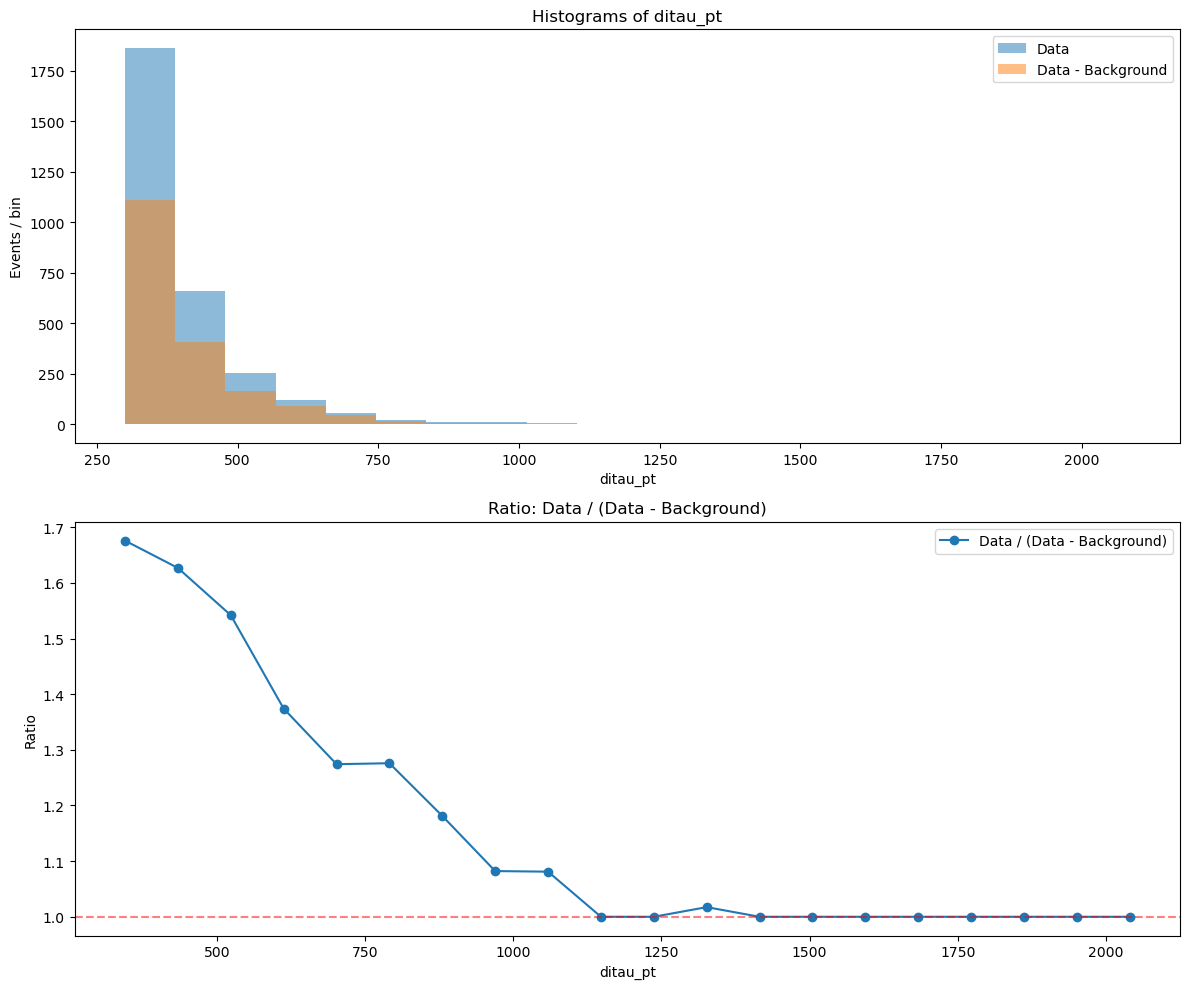

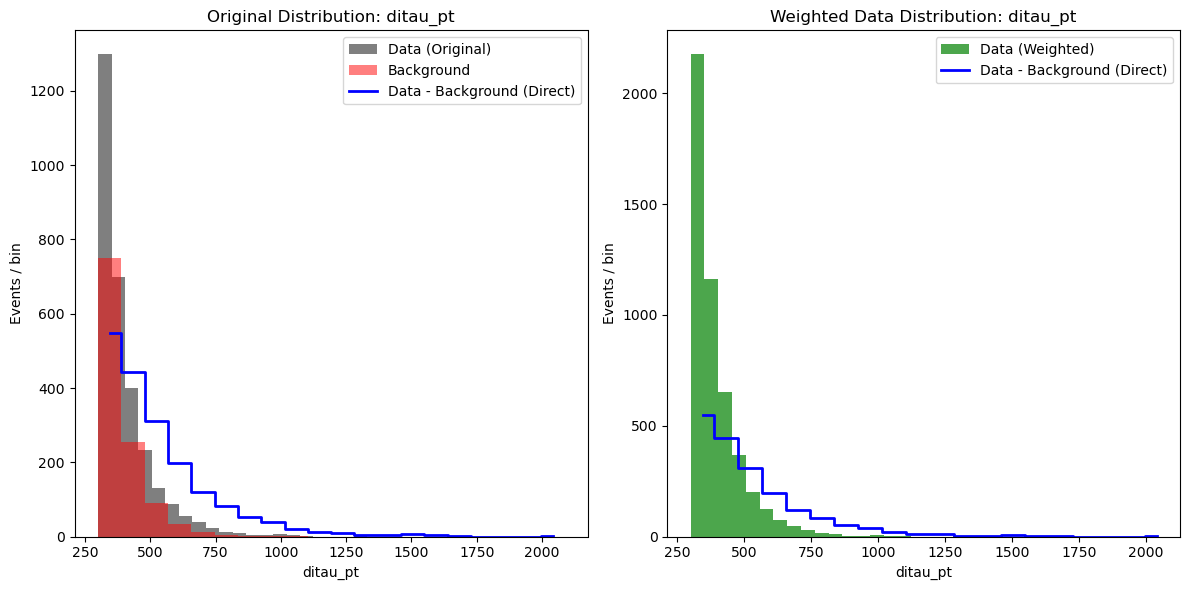

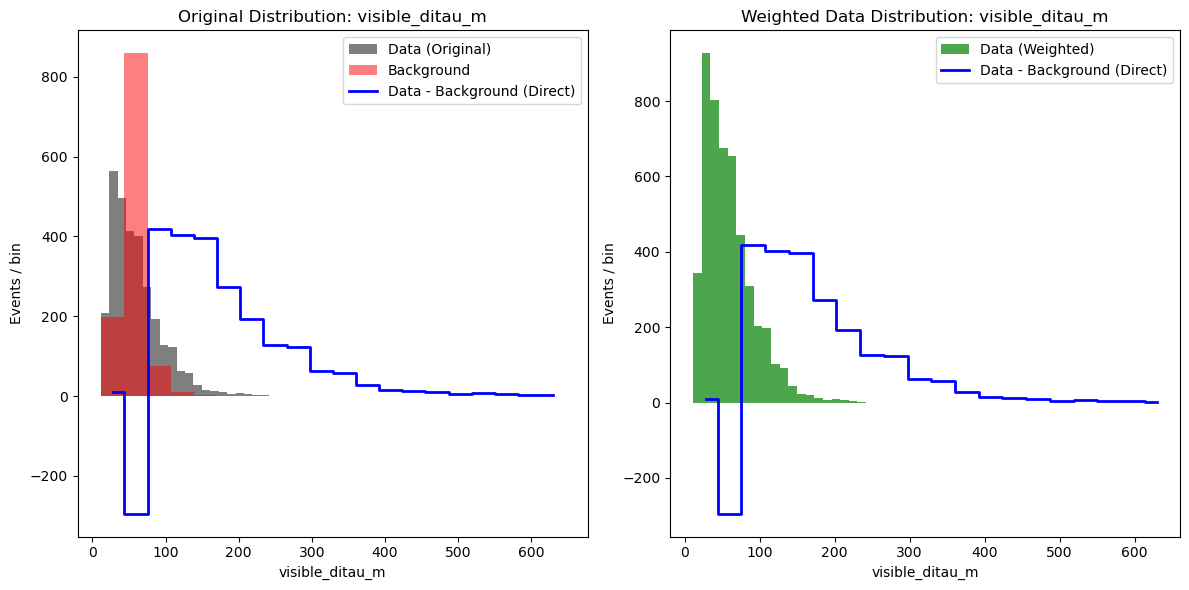

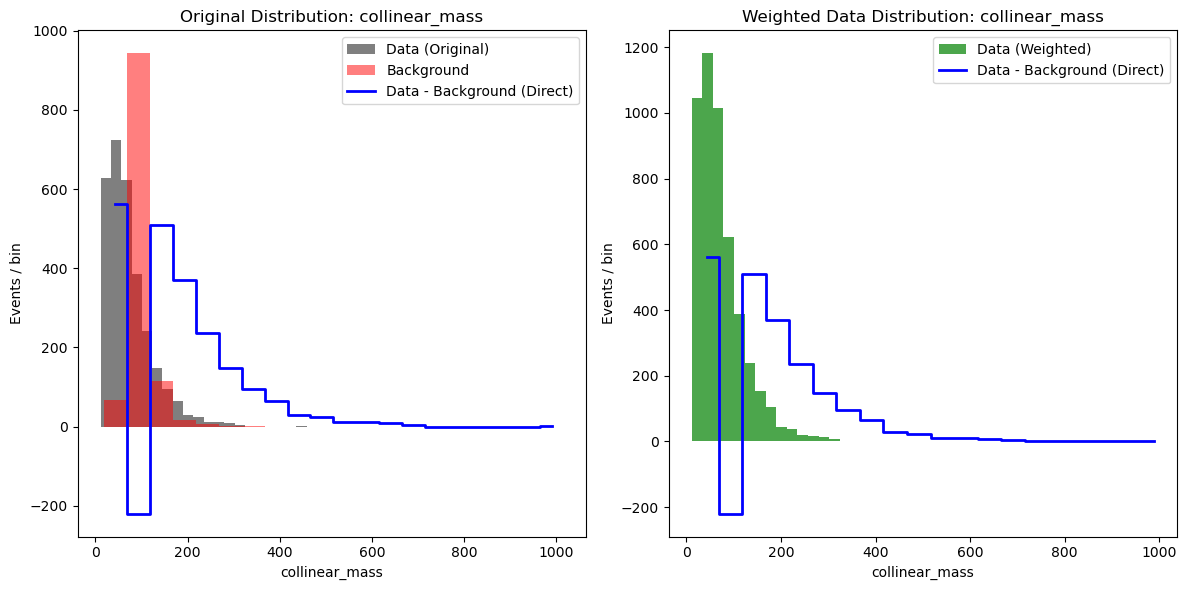

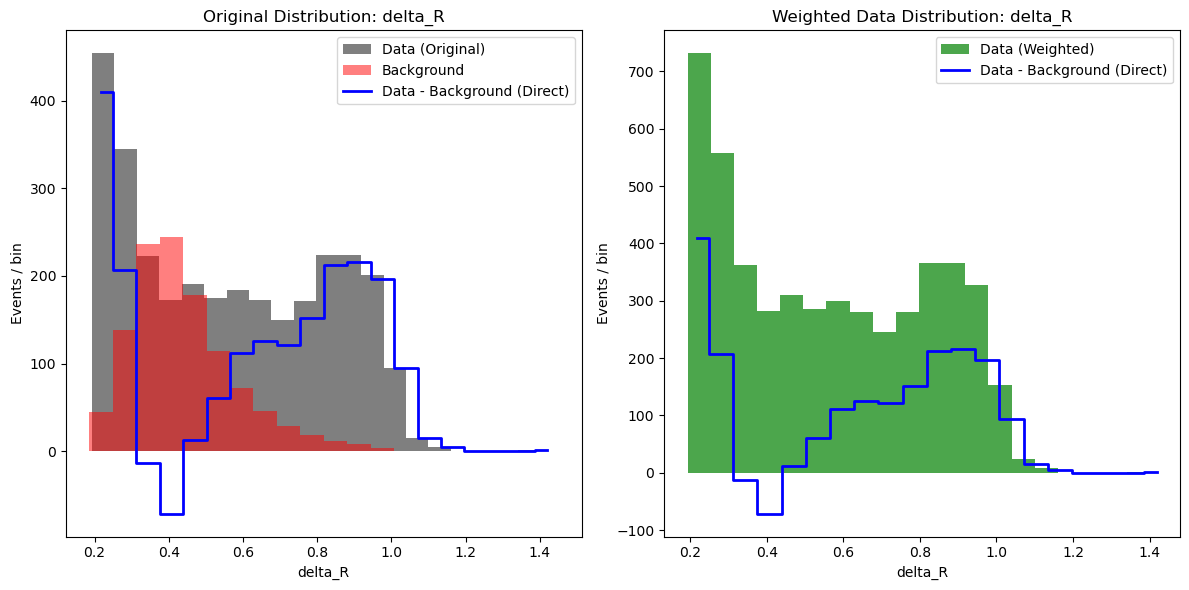

In [30]:
# Define signal and background samples
background_samples = ['vv', 'top', 'ztt', 'w', 'zll']

def calculate_data_minus_mc_weights(df, feature, n_bins=20):
    """
    Calculate weights for data events by creating histograms and taking the ratio:
    weight = (data) / (data - background)
    
    For each bin in the histogram, data events will receive the same weight.
    
    Args:
        df: DataFrame containing all samples
        feature: The feature to use for creating the histogram
        n_bins: Number of bins for the histogram
    
    Returns:
        DataFrame with new 'data_minus_mc_weight' column
    """
    # Create a copy to avoid modifying the original dataframe
    df_result = df.copy()
    
    # Extract data and background samples
    data_df = df_result[df_result['sample_type'] == 'data']
    
    if len(data_df) == 0:
        print("Warning: No data events found")
        return df_result
    
    # Calculate feature range for binning
    feature_min = df_result[feature].min()
    feature_max = df_result[feature].max()
    bin_edges = np.linspace(feature_min, feature_max, n_bins + 1)
    
    # Create histograms
    data_hist, _ = np.histogram(data_df[feature], bins=bin_edges, weights=data_df['combined_weights'])
    bg_hist = np.zeros_like(data_hist)
    
    # Fill background histogram
    for bg_sample in background_samples:
        bg_sample_df = df_result[df_result['sample_type'] == bg_sample]
        if len(bg_sample_df) > 0:
            bg_counts, _ = np.histogram(bg_sample_df[feature], bins=bin_edges, 
                                        weights=bg_sample_df['combined_weights'])
            bg_hist += bg_counts
    
    # Calculate data minus background
    data_minus_bg_hist = data_hist - bg_hist
    
    # Calculate the ratio: data / (data - background)
    # Handle cases where data-background <= 0
    ratio = np.ones_like(data_hist)
    for i in range(len(data_hist)):
        if data_minus_bg_hist[i] > 0 and data_hist[i] > 0:
            ratio[i] = data_hist[i] / data_minus_bg_hist[i]
        elif data_minus_bg_hist[i] <= 0:
            # For bins where background exceeds data, set a reasonable default
            # This is a design choice - could be 0, 1, or some other value
            ratio[i] = 1.0
    
    # Plot the histograms and ratio
    plt.figure(figsize=(12, 10))
    
    # Plot data histogram
    plt.subplot(2, 1, 1)
    plt.stairs(data_hist, bin_edges, fill=True, alpha=0.5, label='Data')
    
    # Plot data-background histogram
    plt.stairs(data_minus_bg_hist, bin_edges, fill=True, alpha=0.5, label='Data - Background')
    
    plt.xlabel(feature)
    plt.ylabel('Events / bin')
    plt.legend()
    plt.title(f'Histograms of {feature}')
    
    # Plot ratio
    plt.subplot(2, 1, 2)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, ratio, 'o-', label='Data / (Data - Background)')
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Ratio')
    plt.legend()
    plt.title(f'Ratio: Data / (Data - Background)')
    
    plt.tight_layout()
    plt.savefig(f'{feature}_ratio.png')
    
    # Assign weights to data events based on which bin they fall into
    df_result['data_minus_mc_weight'] = df_result['combined_weights']  # Initialize with original weights
    
    # For data events only, assign the ratio-based weights
    if len(data_df) > 0:
        data_indices = df_result[df_result['sample_type'] == 'data'].index
        for i, idx in enumerate(data_indices):
            feature_value = df_result.loc[idx, feature]
            # Find which bin this event falls into
            bin_idx = np.digitize(feature_value, bin_edges) - 1
            # Clip bin_idx to be valid for the ratio array.
            # This handles both scalar and array cases for bin_idx.
            bin_idx = np.clip(bin_idx, 0, len(ratio) - 1)
                
            # Assign weight based on ratio
            df_result.loc[idx, 'data_minus_mc_weight'] = ratio[bin_idx] * df_result.loc[idx, 'combined_weights']
    return df_result, ratio, bin_edges

# Function to apply weights from one feature to the whole dataset
def apply_weights_from_feature(df, reference_feature='ditau_pt', n_bins=20):
    """
    Calculate weights based on a reference feature and apply to all data events
    """
    # Calculate weights based on the reference feature
    df_weighted, ratio, bin_edges = calculate_data_minus_mc_weights(df, reference_feature, n_bins)
    
    print(f"Weights calculated from {reference_feature} histogram with {n_bins} bins")
    print(f"Ratio summary - Min: {np.min(ratio):.3f}, Max: {np.max(ratio):.3f}, Mean: {np.mean(ratio):.3f}")
    
    return df_weighted, ratio, bin_edges

# Function to demonstrate the effect of weighting on multiple features
def plot_weighted_distributions(df, features_to_plot, n_bins=20):
    """
    Plot distributions before and after applying weights for selected features
    """
    for feature in features_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Original data and background
        data_df = df[df['sample_type'] == 'data']
        bg_df = df[df['sample_type'].isin(background_samples)]
        
        # Plot original data
        plt.subplot(1, 2, 1)
        plt.hist(data_df[feature], bins=n_bins, weights=data_df['combined_weights'], 
                 alpha=0.5, label='Data (Original)', color='black')
        
        # Plot background
        bg_counts, bg_edges = np.histogram(bg_df[feature], bins=n_bins, weights=bg_df['combined_weights'])
        plt.hist(bg_df[feature], bins=n_bins, weights=bg_df['combined_weights'], 
                 alpha=0.5, label='Background', color='red')
        
        # Calculate and plot data-background directly
        data_counts, data_edges = np.histogram(data_df[feature], bins=n_bins, weights=data_df['combined_weights'])
        data_minus_bg = data_counts - bg_counts
        bin_centers = (bg_edges[:-1] + bg_edges[1:]) / 2
        plt.step(bin_centers, data_minus_bg, where='mid', label='Data - Background (Direct)', color='blue', linewidth=2)
        
        plt.xlabel(feature)
        plt.ylabel('Events / bin')
        plt.legend()
        plt.title(f'Original Distribution: {feature}')
        
        # Plot weighted data
        plt.subplot(1, 2, 2)
        plt.hist(data_df[feature], bins=n_bins, weights=data_df['data_minus_mc_weight'], 
                 alpha=0.7, label='Data (Weighted)', color='green')
        
        # Include the direct data-background again for comparison
        plt.step(bin_centers, data_minus_bg, where='mid', label='Data - Background (Direct)', color='blue', linewidth=2)
        
        plt.xlabel(feature)
        plt.ylabel('Events / bin')
        plt.legend()
        plt.title(f'Weighted Data Distribution: {feature}')
        
        plt.tight_layout()
        plt.savefig(f'{feature}_weighted_comparison.png')

# Apply the implementation to the dataset
# First, select a reference feature for calculating weights
reference_feature = 'ditau_pt'
n_bins = 20

# Calculate weights using the reference feature
df_weighted, ratio, bin_edges = apply_weights_from_feature(df, reference_feature, n_bins)

# Plot weighted distributions for some key features
features_to_plot = ['ditau_pt', 'visible_ditau_m', 'collinear_mass', 'delta_R']
plot_weighted_distributions(df_weighted, features_to_plot)

# Print summary of weights
data_mask = df_weighted['sample_type'] == 'data'
print(f"\nData weights summary:")
print(f"Number of data events: {sum(data_mask)}")
print(f"Original weight sum: {df_weighted.loc[data_mask, 'combined_weights'].sum():.2f}")
print(f"New weight sum: {df_weighted.loc[data_mask, 'data_minus_mc_weight'].sum():.2f}")




Signal: 21.132020457879108


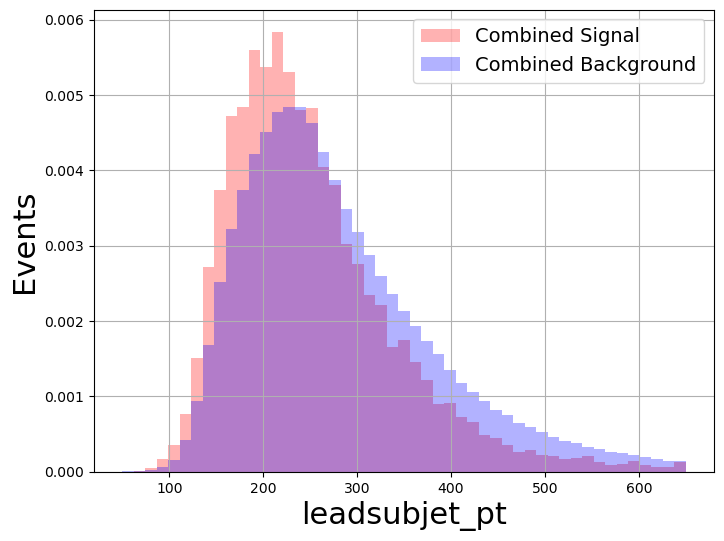

leadsubjet_pt bkg min: 50.00241796875 bkg max: 2162.225
leadsubjet_pt sig min: 71.005375 sig max: 1152.355875
Signal: 16.598481917678647


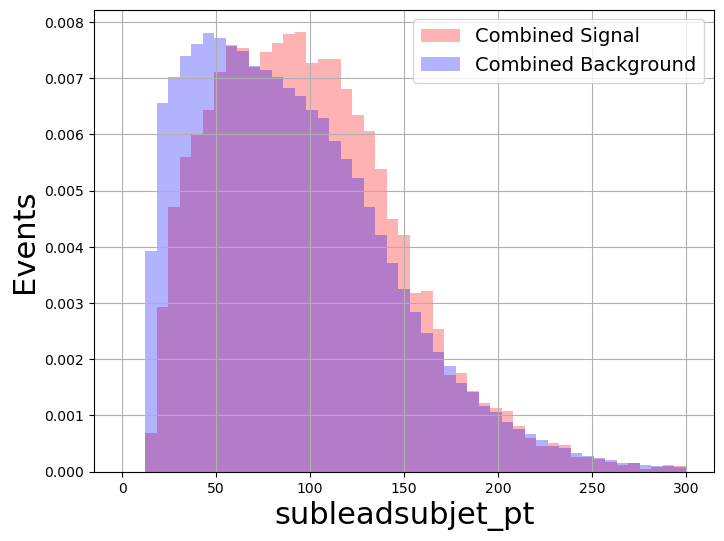

subleadsubjet_pt bkg min: 15.000013671875 bkg max: 652.634125
subleadsubjet_pt sig min: 15.102614257812501 sig max: 436.08459375000007
Signal: 27.08434551627803


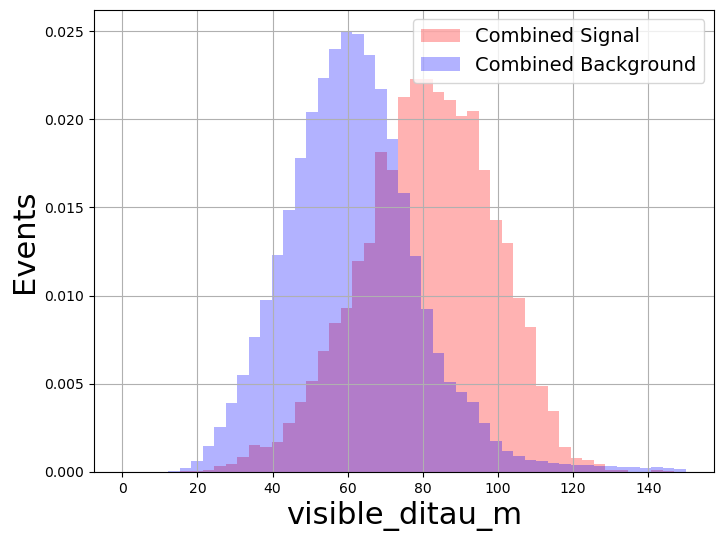

visible_ditau_m bkg min: 8.8042861884768 bkg max: 645.4143173028011
visible_ditau_m sig min: 17.642108199988122 sig max: 144.28401745701666
Signal: 35.96467756450775


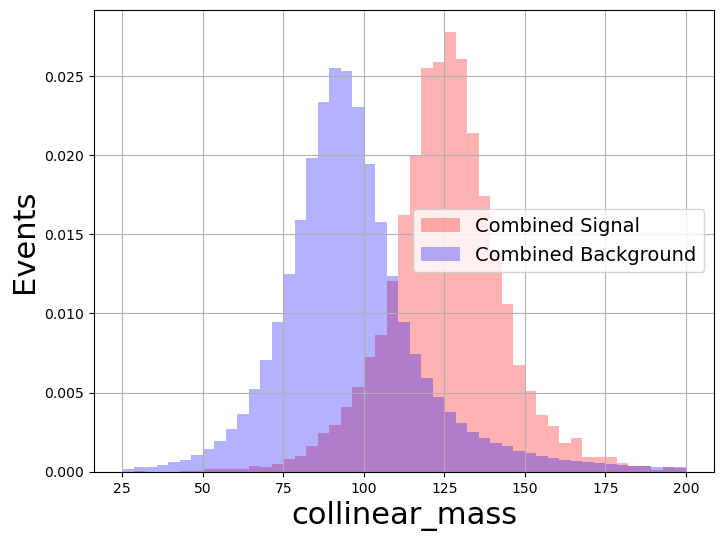

collinear_mass bkg min: 9.434822376469901 bkg max: 1153.338977758933
collinear_mass sig min: 30.677261569201224 sig max: 334.05605138165095
Signal: 35.331462244633585


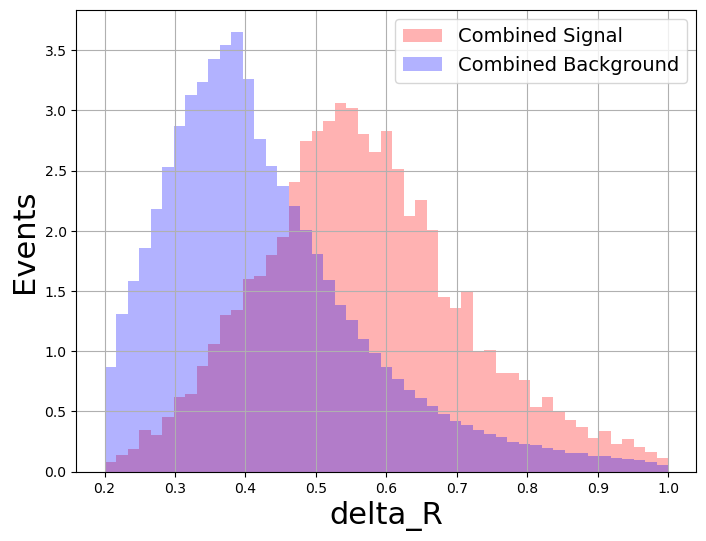

delta_R bkg min: 0.1817814909154357 bkg max: 1.796635393438039
delta_R sig min: 0.20046786338496647 sig max: 1.0920972395562165
Signal: 11.415931486298886


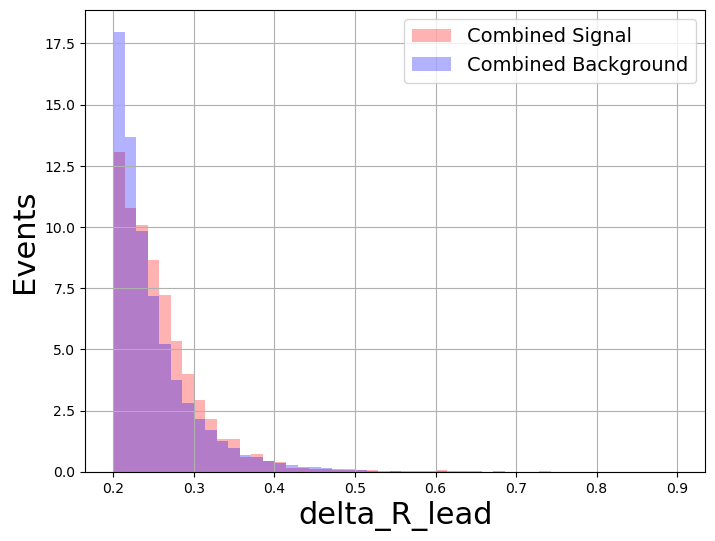

delta_R_lead bkg min: 0.00011969362158029499 bkg max: 0.9329424418136119
delta_R_lead sig min: 0.0019345784235195375 sig max: 0.7343989174684423
Signal: 29.502578275676118


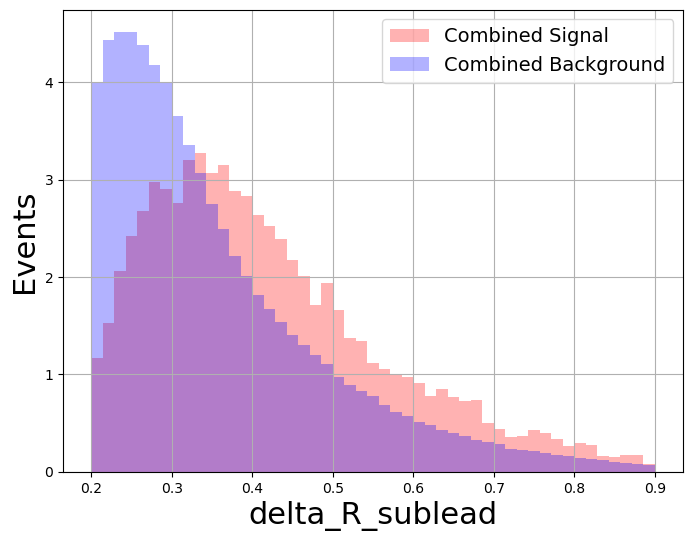

delta_R_sublead bkg min: 0.014764391839357986 bkg max: 1.0046405255192727
delta_R_sublead sig min: 0.0941011443330095 sig max: 0.961545054143488
Signal: 16.077716832531387


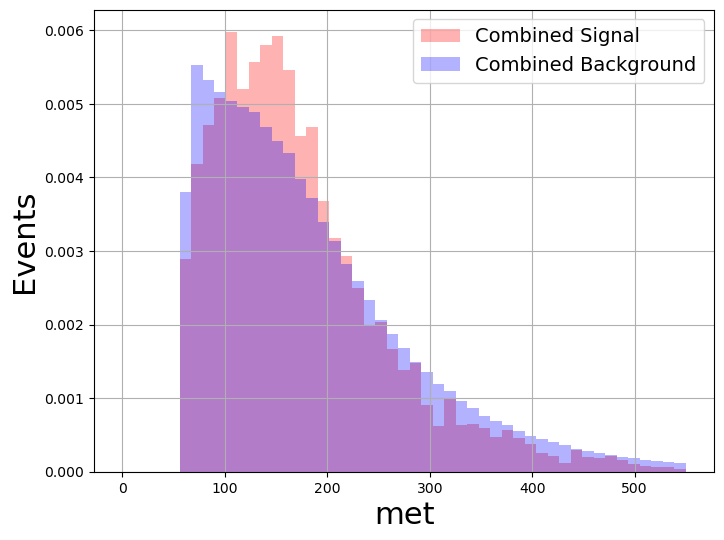

met bkg min: 60.00048796136895 bkg max: 4045.3396388316573
met sig min: 60.02554628373983 sig max: 1137.9765800472244
Signal: 17.822894162980074


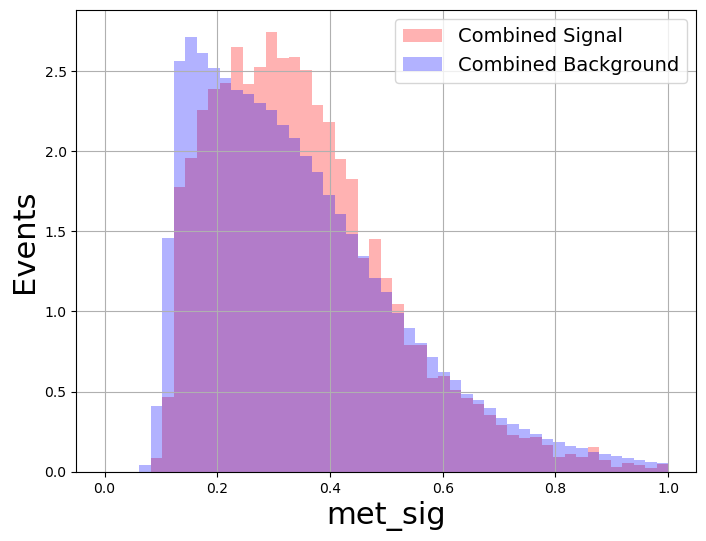

met_sig bkg min: 0.055115452691604436 bkg max: 3.4861190654178893
met_sig sig min: 0.08589813428708105 sig max: 1.5937311901466193
Signal: 19.726229146240325


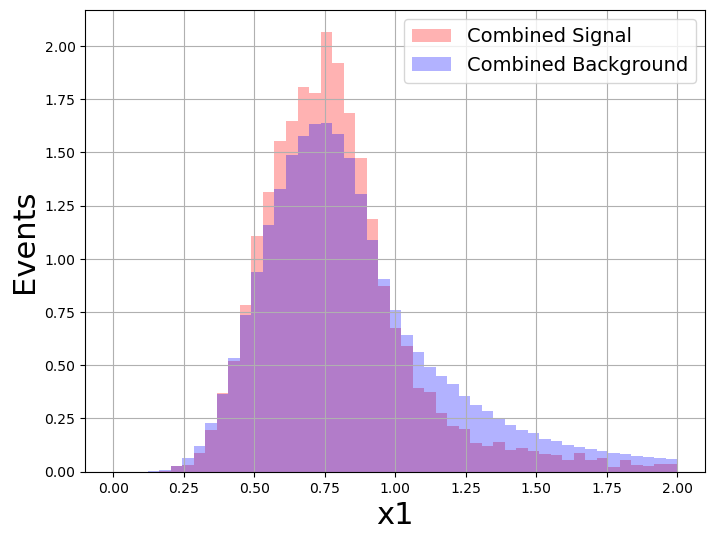

x1 bkg min: 0.09859771504376134 bkg max: 1.9999933120415834
x1 sig min: 0.17937900769321574 sig max: 1.9954783410718127
Signal: 15.601028356423681


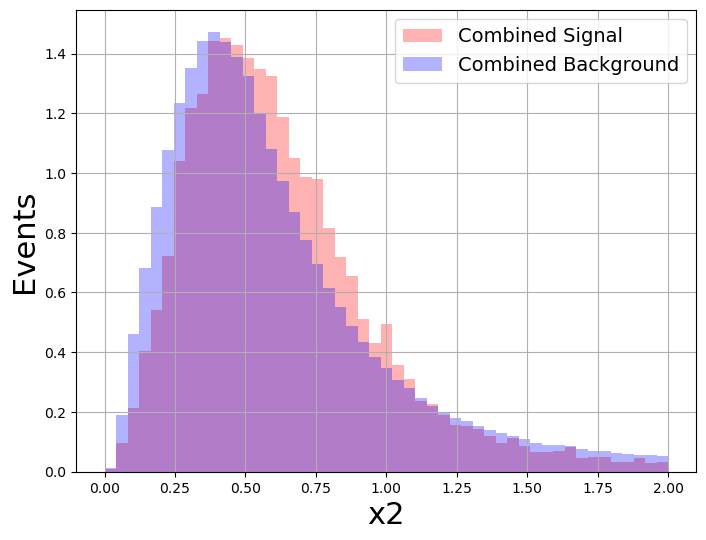

x2 bkg min: 0.01535874203249675 bkg max: 1.9999324234941913
x2 sig min: 0.03485157732351535 sig max: 1.9882013835743935
Signal: 18.648193764409378


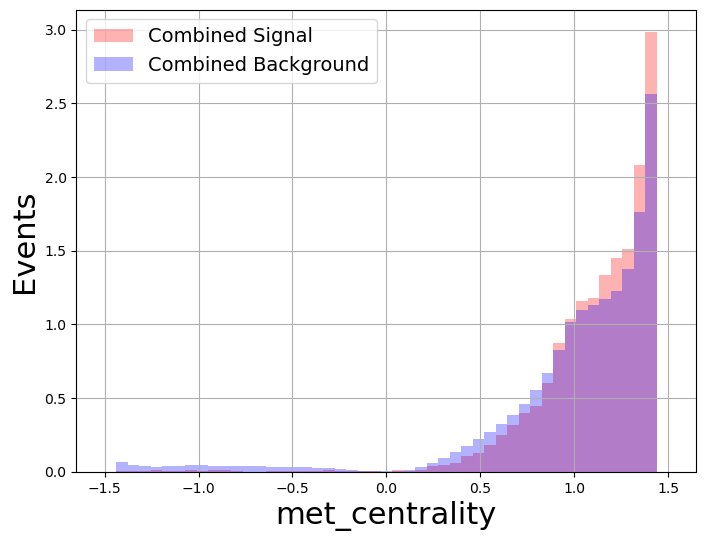

met_centrality bkg min: -1.4142135452877556 bkg max: 1.4142135623713825
met_centrality sig min: -1.4139681113296532 sig max: 1.414213521480775
Signal: -0.014998795770053674


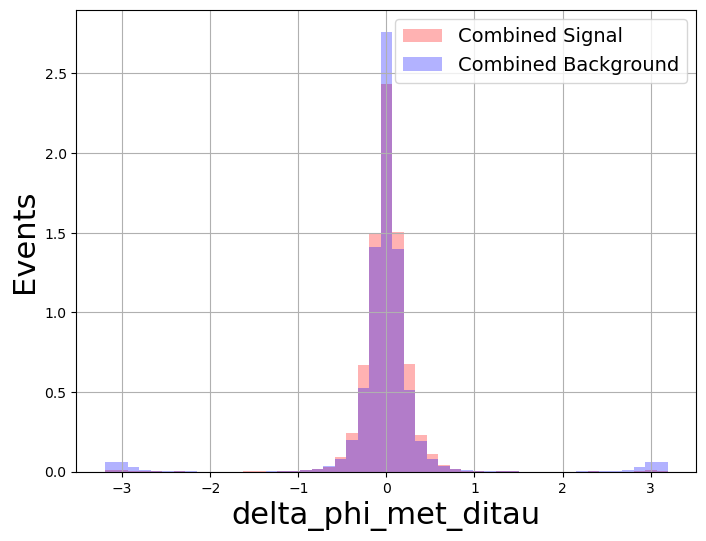

delta_phi_met_ditau bkg min: -3.141587188825506 bkg max: 3.1415822368997155
delta_phi_met_ditau sig min: -3.1337234960582565 sig max: 3.137369191343427
Signal: 123.29466284305073


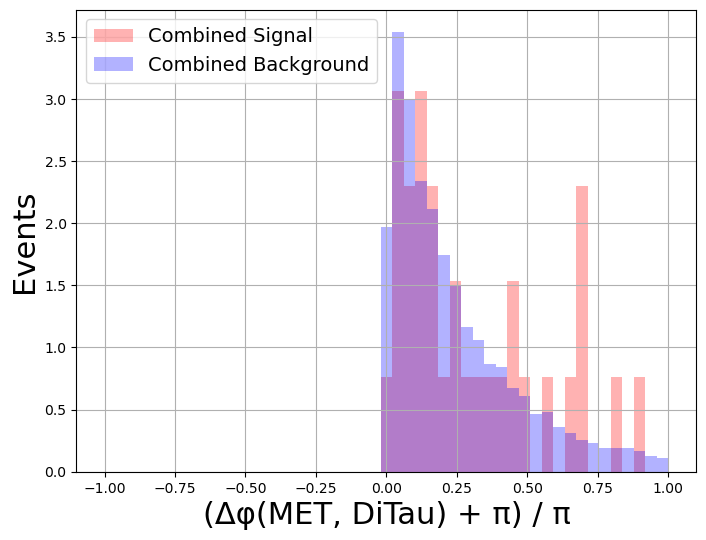

delta_phi_met_ditau_normalized bkg min: 8.584031669307557e-06 bkg max: 9.869588038590846
delta_phi_met_ditau_normalized sig min: 0.0123608437455081 sig max: 9.862970202106409
Signal: 4.601586664820227


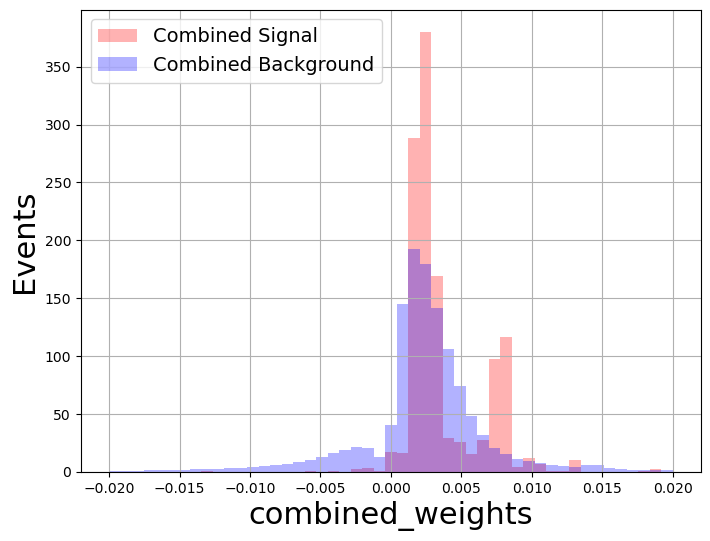

combined_weights bkg min: -0.2742967070590137 bkg max: 1.0
combined_weights sig min: -0.01302151488725651 sig max: 0.019211690871099855


In [26]:
# Define variables and their plotting ranges
plot_configs = {
    'leadsubjet_pt': (50, 650, 50),      # GeV
    'subleadsubjet_pt': (0, 300, 50),   # GeV
    'visible_ditau_m': (0, 150, 50),    # GeV
    'collinear_mass': (25, 200, 50),     # GeV
    'delta_R': (0.2, 1, 50),              # Angular separation
    'delta_R_lead': (0.2, 0.9, 50),              # Angular separation
    'delta_R_sublead': (0.2, 0.9, 50),              # Angular separation
    'met': (0, 550, 50),                # GeV
    'met_sig': (0, 1, 50),             # MET significance
    'x1': (0, 2, 50),                   # Momentum fraction
    'x2': (0, 2, 50),                   # Momentum fraction
    'met_centrality': (-1.5, 1.5, 50),       # Centrality
    'delta_phi_met_ditau': (-3.2, 3.2, 50),    
    'delta_phi_met_ditau_normalized': (-1, 1, 50),     
    'combined_weights': (-0.02, 0.02, 50),  # Combined weights
    # 'leadsubjet_n_core_tracks': (0, 20, 50),       
    # 'subleadsubjet_n_core_tracks': (0, 20, 50),      
    # 'e_ratio_sublead': (0, 1, 50),       # Energy ratio
    # 'e_ratio_lead': (0, 1, 50),       # Energy ratio
    # 'kappa': (0, 1, 50),           # GeV
    # 'k_t': (0, 100, 50),             # GeV
}

# Signal and background processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
# background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, top_plot]
background_processes = [vv_plot, ztt_plot, zll_plot, w_plot, top_plot, data_plot]

# background_processes = [zll_plot]
# Create plot for each variable
for var, (xmin, xmax, nbins) in plot_configs.items():
    plt.figure(figsize=(8, 6))
    plt_bins = np.linspace(xmin, xmax, nbins)
    
    if var == 'delta_phi_met_ditau_normalized':
        # Process signal with the transformation
        combined_signal = np.concatenate([(process['delta_phi_met_ditau'] + np.pi) / 2*np.pi 
                                         for process in signal_processes])
        # Process background with the transformation
        combined_background = np.concatenate([(process['delta_phi_met_ditau'] + np.pi) / 2*np.pi 
                                             for process in background_processes])
    else:
        # Regular plotting for other variables
        combined_signal = np.concatenate([process[var] for process in signal_processes])
        combined_background = np.concatenate([process[var] for process in background_processes])
    
    # Plot signal
    plt.hist(combined_signal, bins=plt_bins, histtype='stepfilled', 
             alpha=0.3, label='Combined Signal', color='red', density=True)
    
    # Plot background
    plt.hist(combined_background, bins=plt_bins, histtype='stepfilled', 
             alpha=0.3, label='Combined Background', color='blue', density=True)
    
    #print area under curve
    print('Signal:', np.sum(combined_signal) / (len(combined_signal) * (xmax - xmin) / nbins))
     
    plt.legend(fontsize=14)
    plt.grid(True)
    
    if var == 'delta_phi_met_ditau_normalized':
        plt.xlabel('(Δφ(MET, DiTau) + π) / π', fontsize=22)
    else:
        plt.xlabel(var, fontsize=22)
        
    plt.ylabel('Events', fontsize=22)
    plt.show()

    #print min and max of each variable
    print(var, 'bkg min:', np.min(combined_background), 'bkg max:', np.max(combined_background))
    print(var, 'sig min:', np.min(combined_signal), 'sig max:', np.max(combined_signal))

signal 8549
signal 0


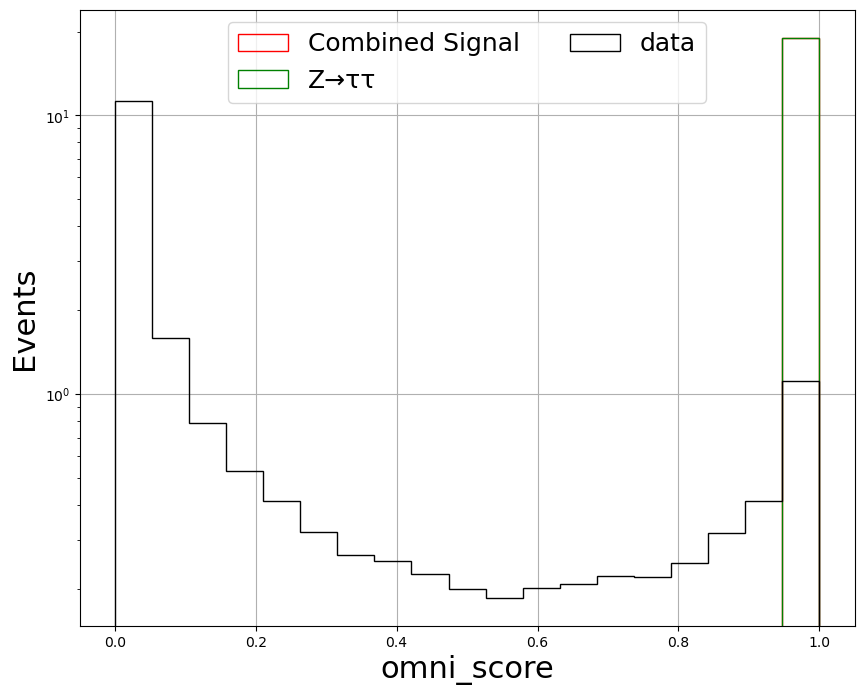

In [45]:
# Setup parameters
plt.figure(figsize=(10, 8))
plot_int = 'omni_score'
plt_bins = np.linspace(0., 1, 20)

# Signal processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
combined_signal = np.concatenate([process[plot_int] for process in signal_processes])
print("signal", len(combined_signal))
print("signal", len(combined_signal[combined_signal < 0.7]))

# Plot signal
plt.hist(combined_signal, bins=plt_bins, histtype='step', 
         label='Combined Signal', color='red', density=True)

# Background samples with labels and colors
backgrounds = {
    # 'VV': (vv_plot, 'blue'),
    'Z→ττ': (ztt_plot, 'green'),
    # 'Z→ll': (zll_plot, 'orange'),
    # 'W': (w_plot, 'purple'),
    # 'ttV': (ttv_plot, 'brown'),
    # 'Top': (top_plot, 'cyan'),
    "data": (data_plot, 'black')
}

# Plot each background
for name, (bkg_process, color) in backgrounds.items():
    plt.hist(bkg_process[plot_int], bins=plt_bins, histtype='step',
             label=name, color=color, density=True)

plt.legend(fontsize=18, ncol=2)
plt.grid(True)
plt.yscale('log')
plt.xlabel(plot_int, fontsize=22)
plt.ylabel('Events', fontsize=22)
plt.show()

In [22]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    495499
1      8640
Name: count, dtype: int64

In [23]:
print(df.loc[df['combined_weights'] < 0, 'combined_weights'])
print(df.loc[df['fake_factor'] < 0, 'fake_factor'])

Series([], Name: combined_weights, dtype: float64)
Series([], Name: fake_factor, dtype: float64)


In [24]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [25]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 168406 167864 167869 0 0
Signal Split: 2816 2885 2939 0 0
Background Split: 165590 164979 164930 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'omni_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'higgs_pt',
       'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta',
       'delta_phi_met_ditau', 'ids'],
      dtype='object')


In [28]:
# # models = []
# signal_scores = []
# background_scores = []
# signal_weights = []
# bkg_weghts = []

# all_shap_values = []
# all_feature_names = []


# n_signal = df['label'].sum()
# n_background = len(df) - n_signal
# alpha_val = n_background / (n_signal + n_background)
# print("Alpha value for Focal Loss:", alpha_val)

# # Define the Focal Loss objective function
# # It must return the gradient (grad) and the hessian (hess)
# def focal_loss_obj(y_true, y_pred):
#     alpha = 0.75  # Balancing parameter (can be tuned)
#     gamma = 2.0   # Focusing parameter (can be tuned)
    
#     p = 1.0 / (1.0 + np.exp(-y_pred))    
#     grad = np.where(y_true == 1, 
#                     -alpha * (1 - p)**gamma * (1 - p), 
#                     (1 - alpha) * p**gamma * p)
#     hess = np.where(y_true == 1, 
#                     alpha * (1 - p)**gamma * (1 - p * (gamma + 1)), 
#                     (1 - alpha) * p**gamma * (1 + p * (gamma - 1)))
    
#     return grad, hess

# bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
# feature_name_mapping = {
#     'leadsubjet_pt': 'f0',
#     'subleadsubjet_pt': 'f1',
#     'visible_ditau_m': 'f2',
#     'collinear_mass': 'f3',
#     'delta_R': 'f4',
#     'met': 'f5',
#     'met_sig': 'f6',
#     'x1': 'f7',
#     'x2': 'f8',
#     'met_centrality': 'f9',
#     'delta_phi_met_ditau': 'f10',
# }

# #map df_split cloumn names 
# for i in range(len(df_split)):
#     df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# # print(df_split[0])
# plt.figure(figsize=(8, 6))

# for i in range(len(df_split)):

#     X_test = df_split[i][bdt_training_var]
#     y_test = df_split[i]['label']
#     evnt_w_test = df_split[i]['combined_weights']
#     ff_test = df_split[i]['fake_factor']

#     X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
#     y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
#     evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
#     ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

#     training_weight = ff_train*evnt_w_train
#     val_weights = ff_test*evnt_w_test

#     print("len X_train:", len(X_train))
#     print("len X_test:", len(X_test))
    
#     params = {
#         'learning_rate': 0.05, 
#         'max_depth': 6, 
#         'n_estimators': 200,
#         'eval_metric': 'logloss',
#         'random_state': 2,
#         # 'scale_pos_weight': scale_pos_weight, # Removed as Focal Loss handles imbalance
#         'base_score': 0.5,
#         'objective': focal_loss_obj, # Use the custom Focal Loss function
#         'gamma': 0.001,
#         'verbosity': 1
#     }

#     model = XGBClassifier(**params)
#     # Train the model
#     model.fit(X_train, y_train, sample_weight=training_weight)
#     # models.append(model)
#     booster = model.get_booster()
#     booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

#     # # Calculate SHAP values
#     explainer = shap.TreeExplainer(model)
#     shap_values = explainer.shap_values(X_test)
#     all_shap_values.append(shap_values)
#     # Reverse the feature_name_mapping
#     reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
#     X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
#     all_feature_names.append(X_test_renamed.columns)
#     # all_feature_names.append(X_test.columns)

#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
#     # Extract scores for signal and background
#     signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
#     background_scores.extend(y_pred_proba[:, 1][y_test == 0])

#     #add scores to df panda frame
#     # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

#     signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
#     bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
#     fpr = fpr[tpr > 0.05]
#     tpr = tpr[tpr > 0.05]
#     roc_auc = auc(fpr, tpr)
#     plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# # plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
# plt.xlabel('Signal Efficiency', fontsize=20)
# plt.ylabel('Background Rejection', fontsize=20)
# plt.legend(fontsize=12)
# plt.yscale('log')
# plt.grid(True, which="both", ls="--")
# plt.show()

len X_train: 335733
len X_test: 168406
signal scaling factor:  56.64646291208791
len X_train: 336275
len X_test: 167864
signal scaling factor:  57.431798436142486
len X_train: 336270
len X_test: 167869
signal scaling factor:  57.98438870373619


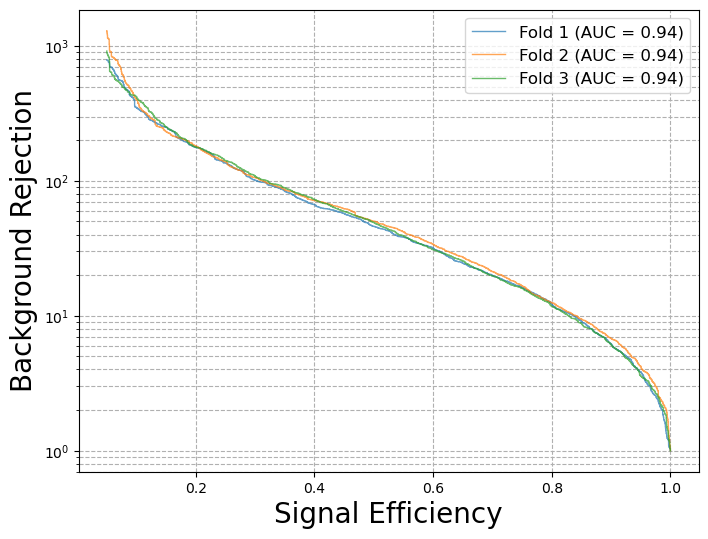

In [29]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

all_shap_values = []
all_feature_names = []

bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'x1': 'f7',
    'x2': 'f8',
    'met_centrality': 'f9',
    'delta_phi_met_ditau': 'f10',
}

#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test

    # training_weight = evnt_w_train
    # val_weights = evnt_w_test

    # training_weight = np.ones(len(y_train))
    # val_weights = np.ones(len(y_test))

    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }

    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    # Reverse the feature_name_mapping
    reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
    X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
    all_feature_names.append(X_test_renamed.columns)
    # all_feature_names.append(X_test.columns)

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    # df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



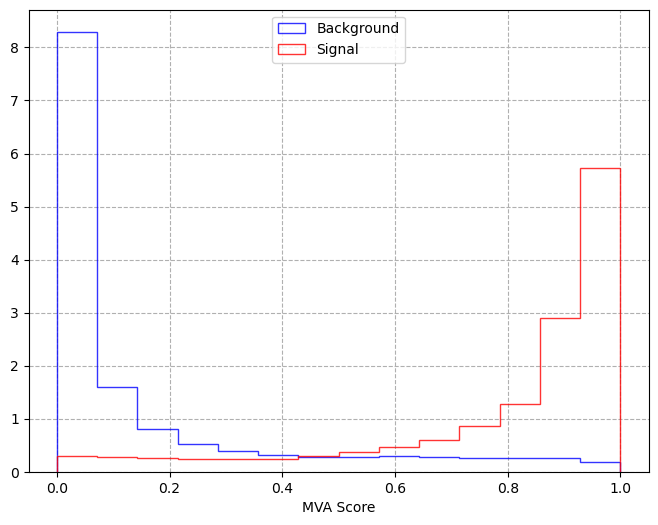

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
# plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

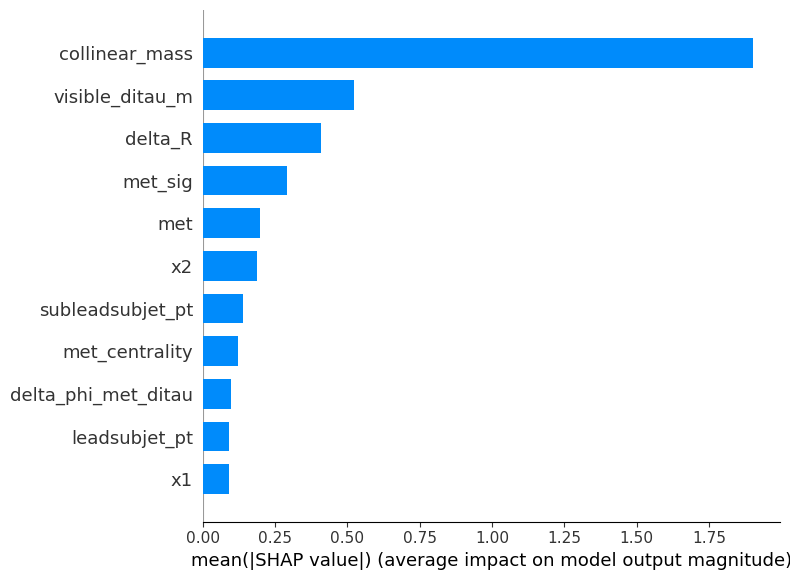

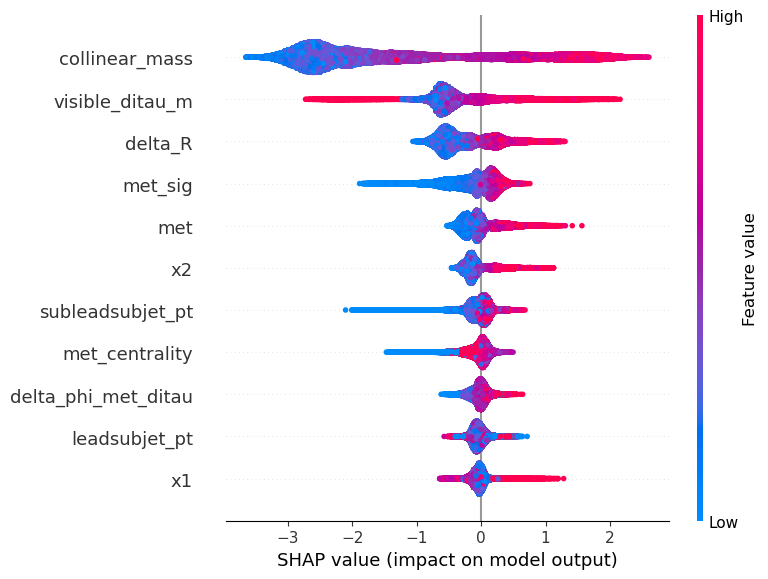

Feature Importance Ranking:
                feature  importance
3        collinear_mass    1.903764
2       visible_ditau_m    0.564735
4               delta_R    0.404995
6               met_sig    0.269088
5                   met    0.183481
8                    x2    0.167565
1      subleadsubjet_pt    0.131586
9        met_centrality    0.125846
7                    x1    0.109256
10  delta_phi_met_ditau    0.099272
0         leadsubjet_pt    0.094854


In [32]:
# Aggregate SHAP values across all folds
mean_shap_values = np.mean([np.abs(shap_values).mean(0) for shap_values in all_shap_values], axis=0)
feature_names = all_feature_names[0]  # Assuming feature names are consistent across folds

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap_values})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
shap.summary_plot(all_shap_values[2], X_test, plot_type="bar", feature_names=feature_names)
shap.summary_plot(all_shap_values[2], X_test, feature_names=feature_names)

# Print feature importance
print("Feature Importance Ranking:")
print(feature_importance)

In [72]:
# sig_hist = plt_to_root_hist_w(signal_scores, 15, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(background_scores, 15, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)